In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
!ls "/content/gdrive/My Drive/COVID-19 Dataset"


Mounted at /content/gdrive
CT  X-ray


In [ ]:

#@markdown #**Anti-Disconnect for Google Colab**
#@markdown ## Run this to stop it from disconnecting automatically 
#@markdown  **(It will anyhow disconnect after 6 - 12 hrs for using the free version of Colab.)**
#@markdown  *(Colab Pro users will get about 24 hrs usage time)*
#@markdown ---
# taken from https://colab.research.google.com/github/justinjohn0306/VQGAN-CLIP/blob/main/VQGAN%2BCLIP_%28z%2Bquantize_method_with_augmentations%2C_user_friendly_interface%29.ipynb#scrollTo=XHyPd4oxVp_l stops colab disconnecting
import IPython
js_code = '''
function ClickConnect(){
console.log("Working");
document.querySelector("colab-toolbar-button#connect").click()
}
setInterval(ClickConnect,60000)
'''
IPython.display.Javascript(js_code)     

<IPython.core.display.Javascript object>

In [ ]:
# import packages

import tensorflow as tf
from keras import datasets, layers, models
import keras as keras
import numpy as np
import pandas as pd
import matplotlib as plt
import os
import graphviz
from keras.utils.vis_utils import plot_model
from keras.models import Sequential
from keras.layers import Dense
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from keras.models import load_model


# for reproducibility - ref https://machinelearningmastery.com/reproducible-results-neural-networks-keras/ and https://www.tensorflow.org/api_docs/python/tf/keras/utils/set_random_seed
np.random.seed(9)
tf.keras.utils.set_random_seed(10)

extensive_COVID_database_CT = os.path.abspath("/content/gdrive/My Drive/COVID-19 Dataset/CT")
extensive_COVID_database_X_Ray = os.path.abspath("/content/gdrive/My Drive/COVID-19 Dataset/X-ray")


# CT CNNs

In [ ]:
#Loading of images based on ref: https://keras.io/examples/vision/image_classification_from_scratch/ 

image_size = (256, 256)
batch_size = 32
train_ds = tf.keras.utils.image_dataset_from_directory(extensive_COVID_database_CT, validation_split=0.3,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    crop_to_aspect_ratio=True
)

val_ds = tf.keras.utils.image_dataset_from_directory(extensive_COVID_database_CT, validation_split=0.3,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    crop_to_aspect_ratio=True
)
# create test set - https://stackoverflow.com/questions/66036271/splitting-a-tensorflow-dataset-into-training-test-and-validation-sets-from-ker
# 20 % now used for test and 10% used for validation
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take((2*val_batches) // 3)
val_ds = val_ds.skip((2*val_batches) // 3)


Found 8054 files belonging to 2 classes.
Using 5638 files for training.
Found 8054 files belonging to 2 classes.
Using 2416 files for validation.


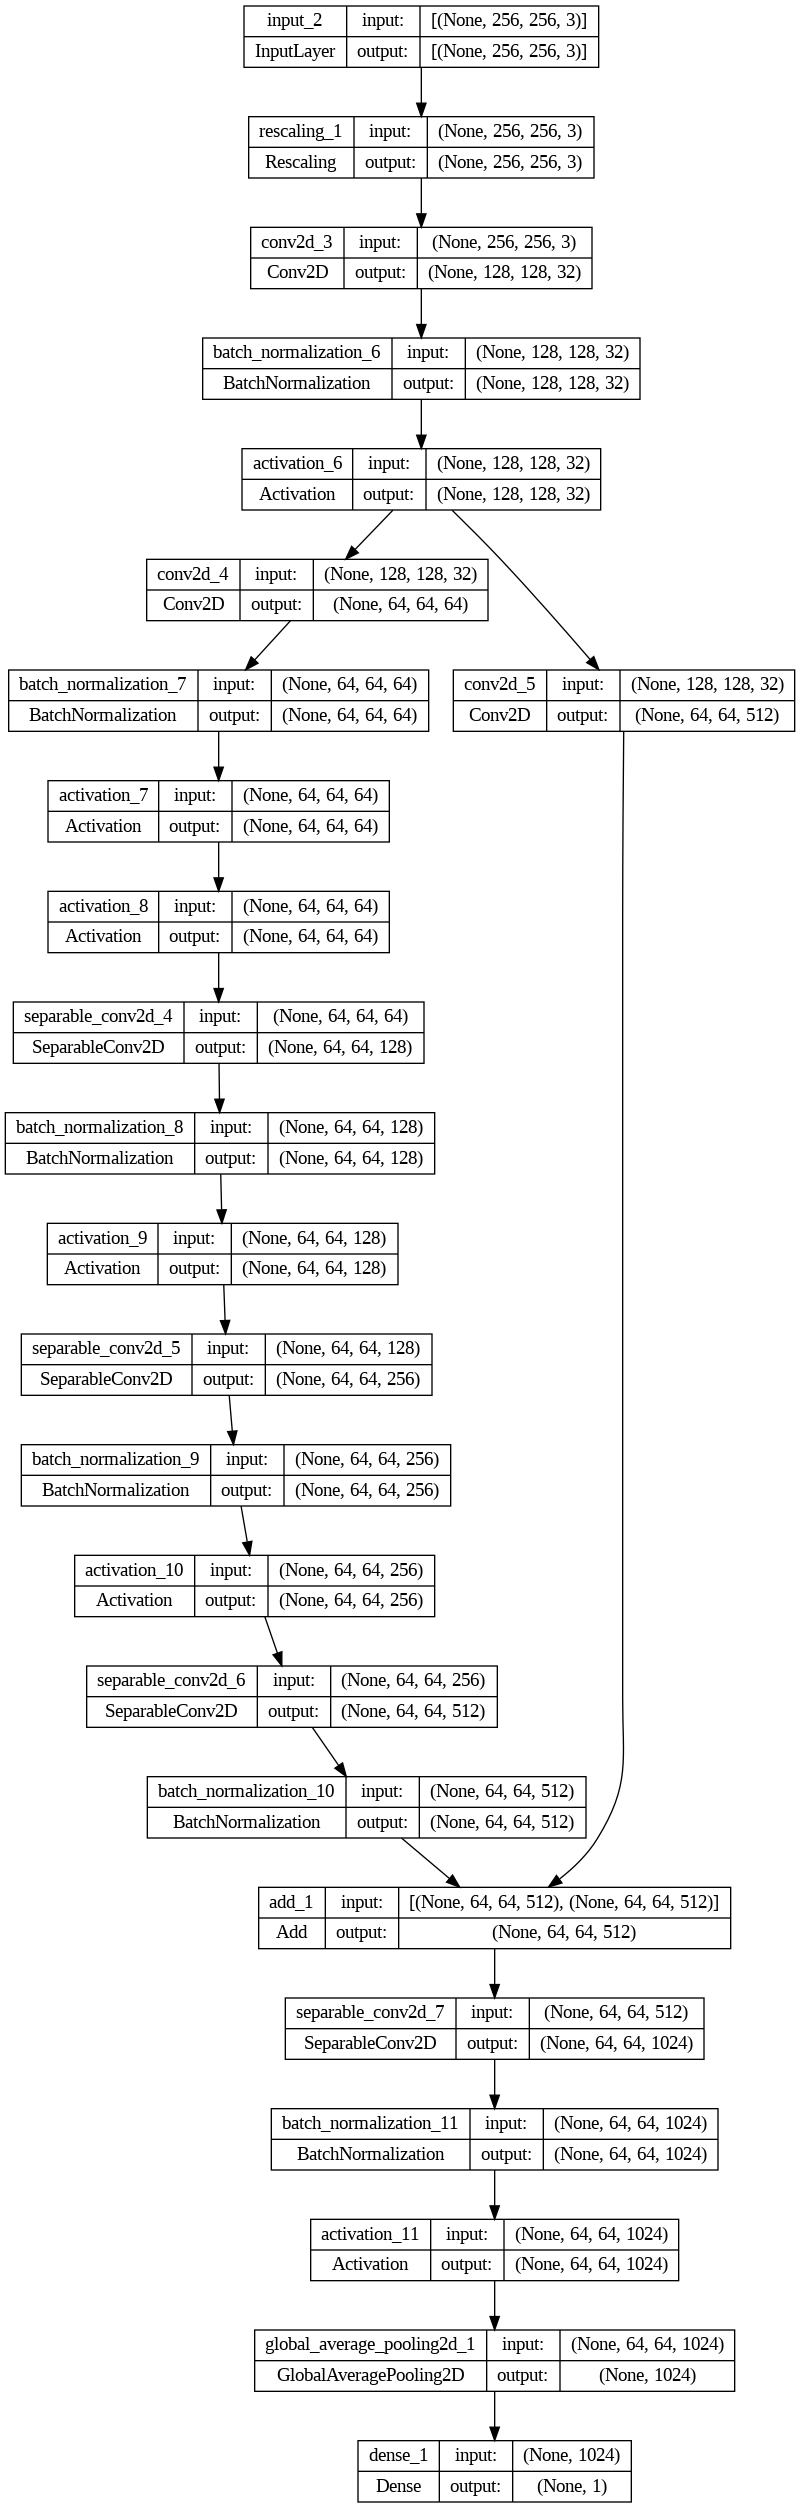

In [ ]:
#CNN Model based on ref: https://keras.io/examples/vision/image_classification_from_scratch/ 


def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)

    x = layers.Conv2D(32, (3,3), strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("ReLU")(x)

    previous_block_activation = x  # Set aside residual
    
    x = layers.Conv2D(64, (3,3), strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("ReLU")(x)

    x = layers.Activation("ReLU")(x)
    x = layers.SeparableConv2D(128, (3,3), padding="same")(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.Activation("ReLU")(x)
    x = layers.SeparableConv2D(256, (3,3), padding="same")(x)
    x = layers.BatchNormalization()(x)

    x = layers.Activation("ReLU")(x)
    x = layers.SeparableConv2D(512, (3,3), padding="same")(x)
    x = layers.BatchNormalization()(x)


    # Project residual
    residual = layers.Conv2D(512, (3,3), strides=2, padding="same")(
          previous_block_activation
      ) 
    x = layers.add([x, residual])  # Add back residual
    previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, (3,3), padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("ReLU")(x)

    x = layers.GlobalAveragePooling2D()(x)
    activation = "sigmoid"
    units = 1
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)
model = make_model(input_shape=(image_size) + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 256, 256, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv2d_3 (Conv2D)              (None, 128, 128, 32  896         ['rescaling_1[0][0]']            
                                )                                                                 
                                                                                            

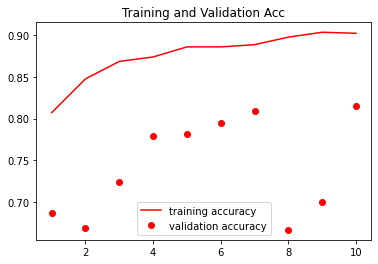

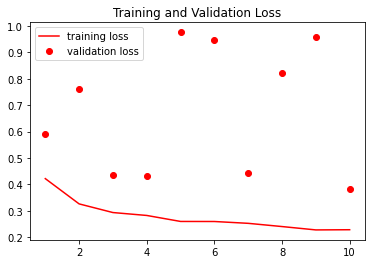

In [ ]:
epochs = 10

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=0.001,momentum=0.001),
    loss="binary_crossentropy",
    metrics=["acc"],
) 
model.summary()
history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds)
model.save('content/gdrive/My Drive/CNN_Models_Baseline/Extensive_COVID19_CT_model.h5')
score = model.evaluate(test_ds)
print('Test Set loss: ' , score[0], ' Test Set accuracy: ', score[1])

print(history.history.keys())

accuracy = history.history['acc']
val_accuracy = history.history['val_acc']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(accuracy) + 1)
accuracy = history.history['acc']
val_accuracy = history.history['val_acc']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy,'r',label = 'training accuracy')
plt.plot(epochs, val_accuracy,'ro',label = 'validation accuracy')
plt.title('Training and Validation Acc')
plt.legend()
plt.show()

plt.plot(epochs, train_loss,'r',label = 'training loss')
plt.plot(epochs, val_loss,'ro',label = 'validation loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()
     


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 dense_2 (Dense)             (None, 256)               524544    
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 21,386,281
Trainable params: 21,331,753
Non-trainable params: 54,528
_________________________________________________________________
Epoch 1/10
177/177 [==============================] - 27s 116ms/step - loss: 0.5777 - acc: 0.6960 - val_loss: 0.3989 - val_acc: 0.7990
Epoch 2/10
177/177 [==============================] - 19s 108ms/step - loss: 0.2255 - acc: 0.9094 - val_loss: 2.2936 - val_acc: 0.6287
Epoch 3/10
177/177 [=============

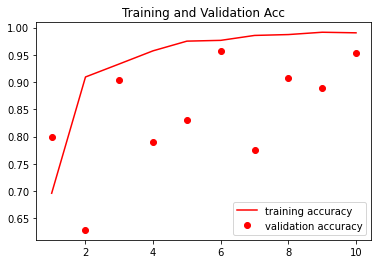

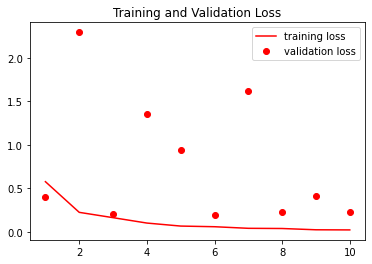

In [ ]:
# code inspired by page 145 - 148 deep learning with python
# and https://www.youtube.com/watch?v=JcU72smpLJk
Xception_model = Sequential()
model = tf.keras.applications.Xception(
    include_top=False,
    weights="imagenet",
    input_shape=(256,256,3),
    pooling='avg',
    classes=2,
    classifier_activation="sigmoid",
)
Xception_model.add(model)
Xception_model.add(Dense(256,activation='relu'))
Xception_model.add(Dense(1,activation='sigmoid'))
epochs = 10

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
Xception_model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=0.001,momentum=0.001),
    loss="binary_crossentropy",
    metrics=["acc"],
) 
Xception_model.summary()
history = Xception_model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds)
Xception_model.save('content/gdrive/My Drive/CNN_Models_Baseline/xception_extensive_covid_CT_model.h5')
score = Xception_model.evaluate(test_ds)
print('Test Set loss: ' , score[0], ' Test Set accuracy: ', score[1])

print(history.history.keys())

accuracy = history.history['acc']
val_accuracy = history.history['val_acc']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(accuracy) + 1)
accuracy = history.history['acc']
val_accuracy = history.history['val_acc']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy,'r',label = 'training accuracy')
plt.plot(epochs, val_accuracy,'ro',label = 'validation accuracy')
plt.title('Training and Validation Acc')
plt.legend()
plt.show()

plt.plot(epochs, train_loss,'r',label = 'training loss')
plt.plot(epochs, val_loss,'ro',label = 'validation loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 2048)              23564800  
                                                                 
 dense_4 (Dense)             (None, 256)               524544    
                                                                 
 dense_5 (Dense)             (None, 1)                 257       
                                                                 
Total params: 24,089,601
Trainable params: 24,044,161
Non-trainable params: 45,440
_________________________________________________________________
Epoch 1/10
177/177 [==============================] - 23s 94ms/step - loss: 0.4392 - acc: 0.7827 - val_loss: 126.2301 - val_acc: 0.3235
Epoch 2/10
177/177 [==============================] - 15s 84ms/step - loss: 0.3005 - acc: 0.8556 - val_loss: 9.1774 - val_acc: 0.6801
Epoch 3/10
177/177 [===========

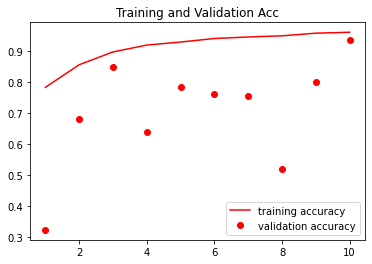

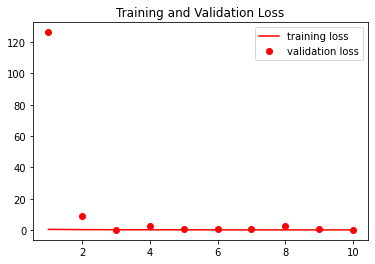

In [ ]:
# code inspired by page 145 - 148 deep learning with python
# and https://www.youtube.com/watch?v=JcU72smpLJk
ResnetModel50V2_model = Sequential()
model = tf.keras.applications.ResNet50V2(
    include_top=False,
    weights="imagenet",
    input_shape=(256,256,3),
    pooling='avg',
    classes=2,
    classifier_activation="sigmoid",
)
ResnetModel50V2_model.add(model)
ResnetModel50V2_model.add(Dense(256,activation='relu'))
ResnetModel50V2_model.add(Dense(1,activation='sigmoid'))
epochs = 10

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
ResnetModel50V2_model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=0.001,momentum=0.001),
    loss="binary_crossentropy",
    metrics=["acc"],
) 
ResnetModel50V2_model.summary()
history = ResnetModel50V2_model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds)
ResnetModel50V2_model.save('content/gdrive/My Drive/CNN_Models_Baseline/resnetmodel50v2_extensive_covid_CT_model.h5')
score = ResnetModel50V2_model.evaluate(test_ds)
print('Test Set loss: ' , score[0], ' Test Set accuracy: ', score[1])

print(history.history.keys())

accuracy = history.history['acc']
val_accuracy = history.history['val_acc']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(accuracy) + 1)
accuracy = history.history['acc']
val_accuracy = history.history['val_acc']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy,'r',label = 'training accuracy')
plt.plot(epochs, val_accuracy,'ro',label = 'validation accuracy')
plt.title('Training and Validation Acc')
plt.legend()
plt.show()

plt.plot(epochs, train_loss,'r',label = 'training loss')
plt.plot(epochs, val_loss,'ro',label = 'validation loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-s (Functiona  (None, 1280)             20331360  
 l)                                                              
                                                                 
 dense_6 (Dense)             (None, 256)               327936    
                                                                 
 dense_7 (Dense)             (None, 1)                 257       
                                                                 
Total params: 20,659,553
Trainable params: 20,505,681
Non-trainable params: 153,872
_________________________________________________________________
Epoch 1/10
177/177 [==============================] - 50s 175ms/step - loss: 0.2660 - acc: 0.8863 - val_loss: 0.2378 - val_acc: 0.9069
Epoch 2/10
177/177 [==============================] - 28s 154ms/step - loss: 0.1533 - acc: 0.9406 -

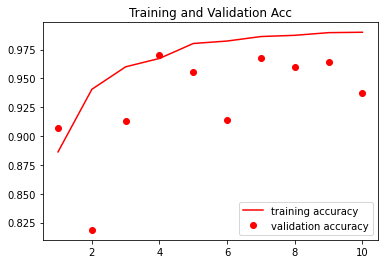

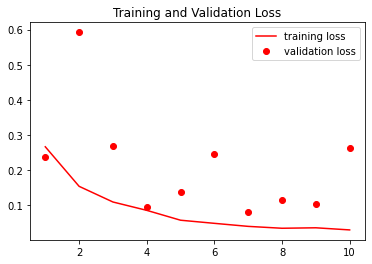

In [ ]:
# code inspired by page 145 - 148 deep learning with python
# and https://www.youtube.com/watch?v=JcU72smpLJk
EfficientNetV2S_model	= Sequential()
model = tf.keras.applications.EfficientNetV2S(
    include_top=False,
    weights="imagenet",
    input_shape=(256,256,3),
    pooling='avg',
    classes=2,
    classifier_activation="sigmoid",
)
EfficientNetV2S_model.add(model)
EfficientNetV2S_model.add(Dense(256,activation='relu'))
EfficientNetV2S_model.add(Dense(1,activation='sigmoid'))
epochs = 10

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
EfficientNetV2S_model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=0.001,momentum=0.001),
    loss="binary_crossentropy",
    metrics=["acc"],
) 
EfficientNetV2S_model.summary()
history = EfficientNetV2S_model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds)
EfficientNetV2S_model.save('content/gdrive/My Drive/CNN_Models_Baseline/efficient_net_V2S_extensive_covid_CT_model.h5')
score = EfficientNetV2S_model.evaluate(test_ds)
print('Test Set loss: ' , score[0], ' Test Set accuracy: ', score[1])

print(history.history.keys())

accuracy = history.history['acc']
val_accuracy = history.history['val_acc']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(accuracy) + 1)
accuracy = history.history['acc']
val_accuracy = history.history['val_acc']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy,'r',label = 'training accuracy')
plt.plot(epochs, val_accuracy,'ro',label = 'validation accuracy')
plt.title('Training and Validation Acc')
plt.legend()
plt.show()

plt.plot(epochs, train_loss,'r',label = 'training loss')
plt.plot(epochs, val_loss,'ro',label = 'validation loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()
     


# X-Ray CNNS

In [ ]:
#Loading of images based on ref: https://keras.io/examples/vision/image_classification_from_scratch/ 

image_size = (256, 256)
batch_size = 32
train_ds = tf.keras.utils.image_dataset_from_directory(extensive_COVID_database_X_Ray, validation_split=0.3,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    crop_to_aspect_ratio=True
)

val_ds = tf.keras.utils.image_dataset_from_directory(extensive_COVID_database_X_Ray, validation_split=0.3,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    crop_to_aspect_ratio=True
)
# create test set - https://stackoverflow.com/questions/66036271/splitting-a-tensorflow-dataset-into-training-test-and-validation-sets-from-ker
# 20 % now used for test and 10% used for validation
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take((2*val_batches) // 3)
val_ds = val_ds.skip((2*val_batches) // 3)


Found 9537 files belonging to 2 classes.
Using 6676 files for training.
Found 9537 files belonging to 2 classes.
Using 2861 files for validation.


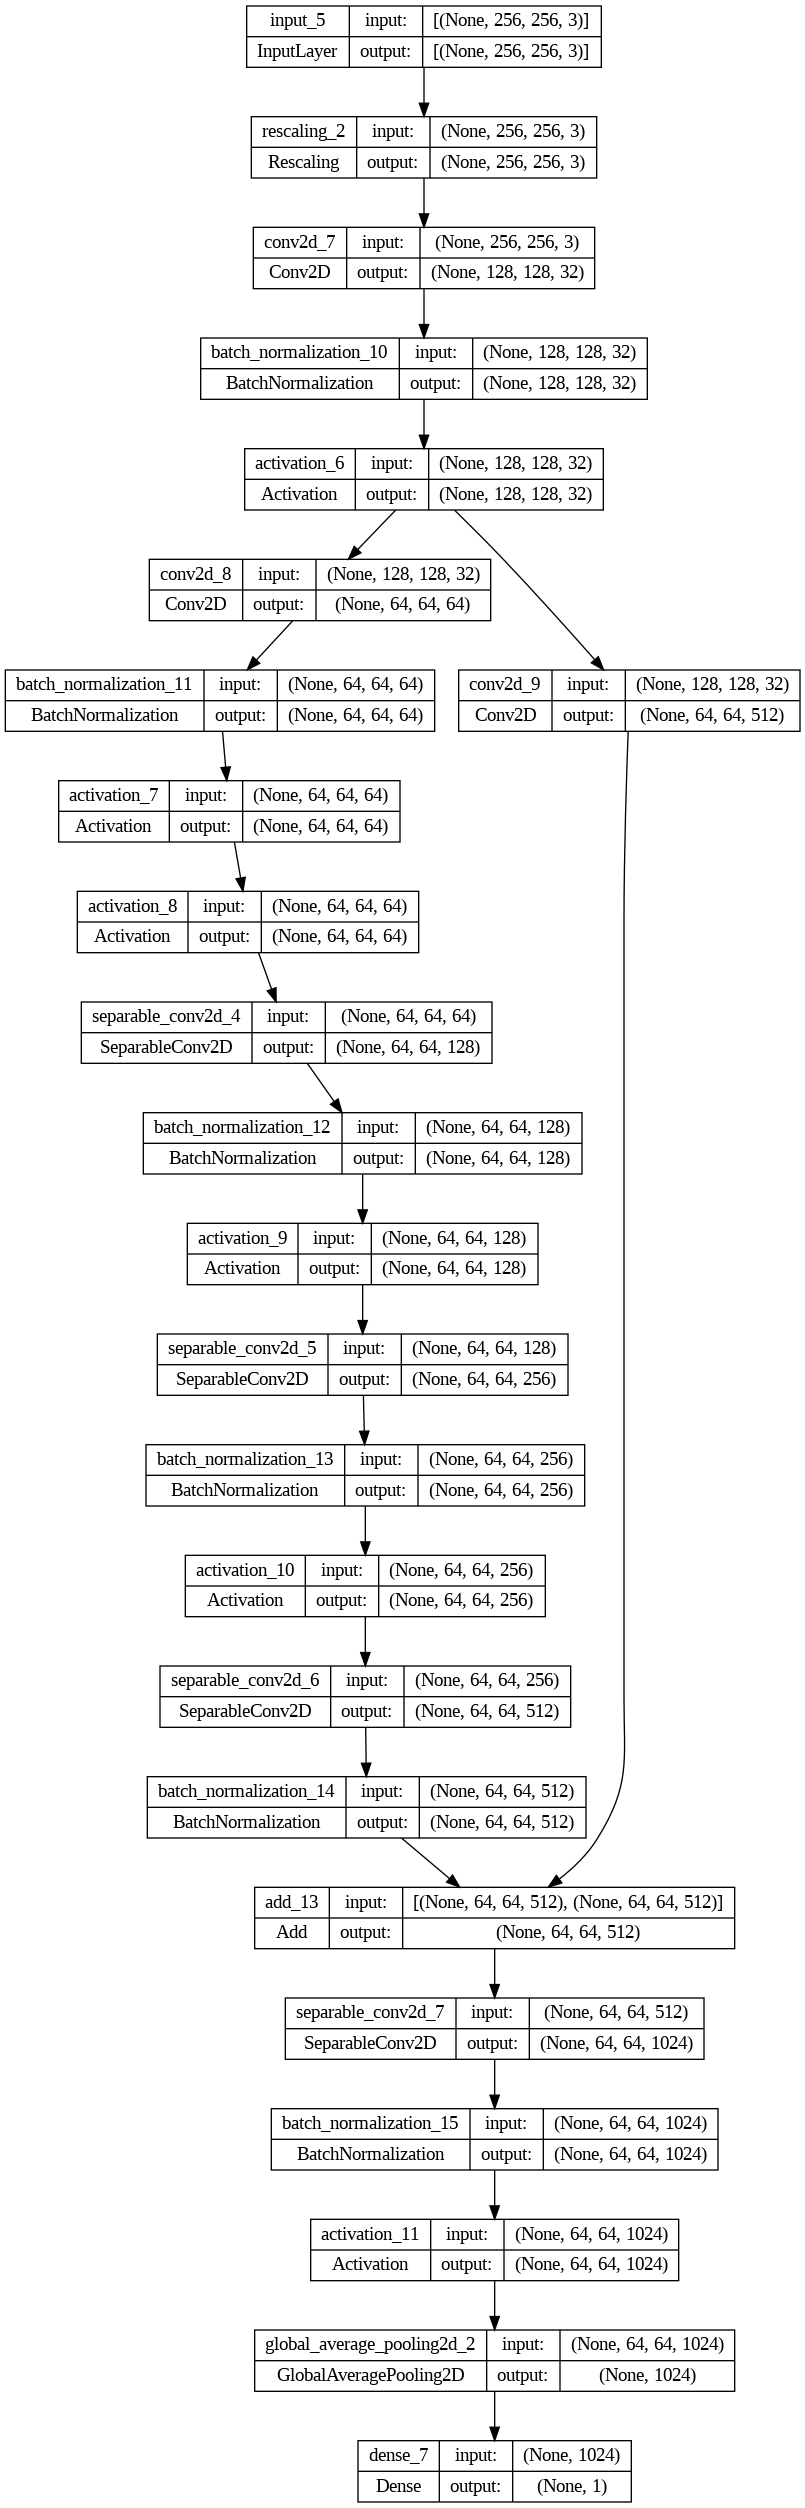

In [ ]:
#CNN Model based on ref: https://keras.io/examples/vision/image_classification_from_scratch/ 


def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)

    x = layers.Conv2D(32, (3,3), strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("ReLU")(x)

    previous_block_activation = x  # Set aside residual
    
    x = layers.Conv2D(64, (3,3), strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("ReLU")(x)

    x = layers.Activation("ReLU")(x)
    x = layers.SeparableConv2D(128, (3,3), padding="same")(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.Activation("ReLU")(x)
    x = layers.SeparableConv2D(256, (3,3), padding="same")(x)
    x = layers.BatchNormalization()(x)

    x = layers.Activation("ReLU")(x)
    x = layers.SeparableConv2D(512, (3,3), padding="same")(x)
    x = layers.BatchNormalization()(x)


    # Project residual
    residual = layers.Conv2D(512, (3,3), strides=2, padding="same")(
          previous_block_activation
      ) 
    x = layers.add([x, residual])  # Add back residual
    previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, (3,3), padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("ReLU")(x)

    x = layers.GlobalAveragePooling2D()(x)
    activation = "sigmoid"
    units = 1
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)
model = make_model(input_shape=(image_size) + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_2 (Rescaling)        (None, 256, 256, 3)  0           ['input_5[0][0]']                
                                                                                                  
 conv2d_7 (Conv2D)              (None, 128, 128, 32  896         ['rescaling_2[0][0]']            
                                )                                                                 
                                                                                            

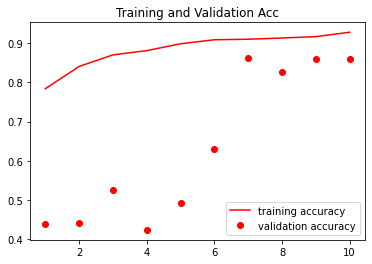

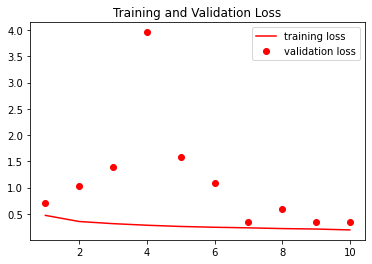

In [ ]:
epochs = 10

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=0.001,momentum=0.001),
    loss="binary_crossentropy",
    metrics=["acc"],
) 
model.summary()
history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds)
model.save('content/gdrive/My Drive/CNN_Models_Baseline/Extensive_COVID19_XRAY_model.h5')
score = model.evaluate(test_ds)
print('Test Set loss: ' , score[0], ' Test Set accuracy: ', score[1])

print(history.history.keys())

accuracy = history.history['acc']
val_accuracy = history.history['val_acc']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(accuracy) + 1)
accuracy = history.history['acc']
val_accuracy = history.history['val_acc']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy,'r',label = 'training accuracy')
plt.plot(epochs, val_accuracy,'ro',label = 'validation accuracy')
plt.title('Training and Validation Acc')
plt.legend()
plt.show()

plt.plot(epochs, train_loss,'r',label = 'training loss')
plt.plot(epochs, val_loss,'ro',label = 'validation loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()
     


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 dense_8 (Dense)             (None, 256)               524544    
                                                                 
 dense_9 (Dense)             (None, 1)                 257       
                                                                 
Total params: 21,386,281
Trainable params: 21,331,753
Non-trainable params: 54,528
_________________________________________________________________
Epoch 1/10
209/209 [==============================] - 38s 155ms/step - loss: 0.2595 - acc: 0.8954 - val_loss: 0.9326 - val_acc: 0.7407
Epoch 2/10
209/209 [==============================] - 32s 148ms/step - loss: 0.1229 - acc: 0.9579 - val_loss: 0.1983 - val_acc: 0.9384
Epoch 3/10
209/209 [===========

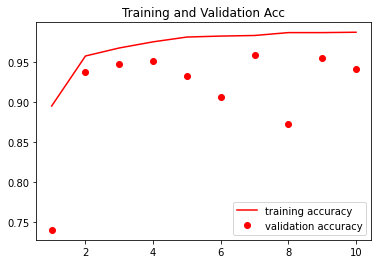

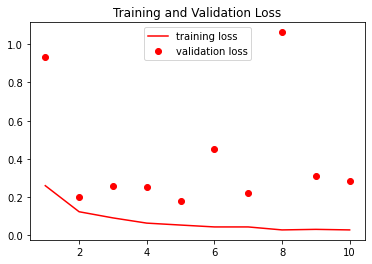

In [ ]:
# code inspired by page 145 - 148 deep learning with python
# and https://www.youtube.com/watch?v=JcU72smpLJk
Xception_model = Sequential()
model = tf.keras.applications.Xception(
    include_top=False,
    weights="imagenet",
    input_shape=(256,256,3),
    pooling='avg',
    classes=2,
    classifier_activation="sigmoid",
)
Xception_model.add(model)
Xception_model.add(Dense(256,activation='relu'))
Xception_model.add(Dense(1,activation='sigmoid'))
epochs = 10

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
Xception_model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=0.001,momentum=0.001),
    loss="binary_crossentropy",
    metrics=["acc"],
) 
Xception_model.summary()
history = Xception_model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds)
Xception_model.save('content/gdrive/My Drive/CNN_Models_Baseline/xception_extensive_covid_Xray_model.h5')
score = Xception_model.evaluate(test_ds)
print('Test Set loss: ' , score[0], ' Test Set accuracy: ', score[1])

print(history.history.keys())

accuracy = history.history['acc']
val_accuracy = history.history['val_acc']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(accuracy) + 1)
accuracy = history.history['acc']
val_accuracy = history.history['val_acc']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy,'r',label = 'training accuracy')
plt.plot(epochs, val_accuracy,'ro',label = 'validation accuracy')
plt.title('Training and Validation Acc')
plt.legend()
plt.show()

plt.plot(epochs, train_loss,'r',label = 'training loss')
plt.plot(epochs, val_loss,'ro',label = 'validation loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 2048)              23564800  
                                                                 
 dense_10 (Dense)            (None, 256)               524544    
                                                                 
 dense_11 (Dense)            (None, 1)                 257       
                                                                 
Total params: 24,089,601
Trainable params: 24,044,161
Non-trainable params: 45,440
_________________________________________________________________
Epoch 1/10
209/209 [==============================] - 39s 153ms/step - loss: 0.3914 - acc: 0.8310 - val_loss: 4.3715 - val_acc: 0.4506
Epoch 2/10
209/209 [==============================] - 31s 145ms/step - loss: 0.2603 - acc: 0.8996 - val_loss: 5.7999 - val_acc: 0.5792
Epoch 3/10
209/209 [===========

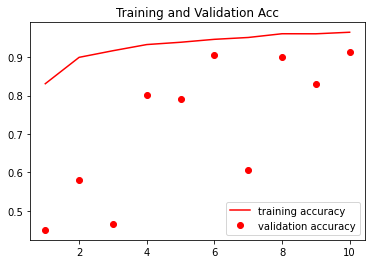

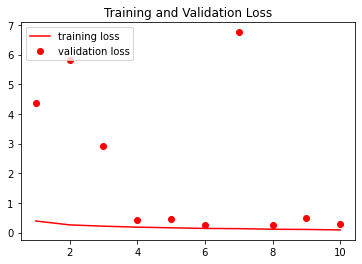

In [ ]:
# code inspired by page 145 - 148 deep learning with python
# and https://www.youtube.com/watch?v=JcU72smpLJk
ResnetModel50V2_model = Sequential()
model = tf.keras.applications.ResNet50V2(
    include_top=False,
    weights="imagenet",
    input_shape=(256,256,3),
    pooling='avg',
    classes=2,
    classifier_activation="sigmoid",
)
ResnetModel50V2_model.add(model)
ResnetModel50V2_model.add(Dense(256,activation='relu'))
ResnetModel50V2_model.add(Dense(1,activation='sigmoid'))
epochs = 10

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
ResnetModel50V2_model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=0.001,momentum=0.001),
    loss="binary_crossentropy",
    metrics=["acc"],
) 
ResnetModel50V2_model.summary()
history = ResnetModel50V2_model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds)
ResnetModel50V2_model.save('content/gdrive/My Drive/CNN_Models_Baseline/resnetmodel50v2_extensive_covid_Xray_model.h5')
score = ResnetModel50V2_model.evaluate(test_ds)
print('Test Set loss: ' , score[0], ' Test Set accuracy: ', score[1])

print(history.history.keys())

accuracy = history.history['acc']
val_accuracy = history.history['val_acc']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(accuracy) + 1)
accuracy = history.history['acc']
val_accuracy = history.history['val_acc']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy,'r',label = 'training accuracy')
plt.plot(epochs, val_accuracy,'ro',label = 'validation accuracy')
plt.title('Training and Validation Acc')
plt.legend()
plt.show()

plt.plot(epochs, train_loss,'r',label = 'training loss')
plt.plot(epochs, val_loss,'ro',label = 'validation loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-s (Functiona  (None, 1280)             20331360  
 l)                                                              
                                                                 
 dense_12 (Dense)            (None, 256)               327936    
                                                                 
 dense_13 (Dense)            (None, 1)                 257       
                                                                 
Total params: 20,659,553
Trainable params: 20,505,681
Non-trainable params: 153,872
_________________________________________________________________
Epoch 1/10
209/209 [==============================] - 62s 200ms/step - loss: 0.2389 - acc: 0.9113 - val_loss: 0.2087 - val_acc: 0.9267
Epoch 2/10
209/209 [==============================] - 39s 184ms/step - loss: 0.1340 - acc: 0.9570 -

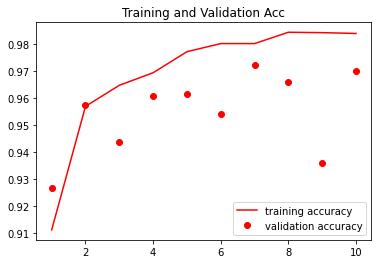

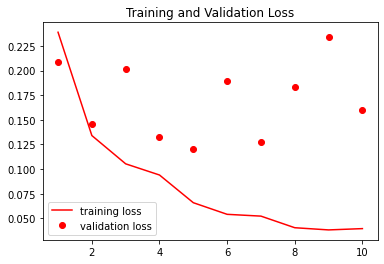

In [ ]:
# code inspired by page 145 - 148 deep learning with python
# and https://www.youtube.com/watch?v=JcU72smpLJk
EfficientNetV2S_model	= Sequential()
model = tf.keras.applications.EfficientNetV2S(
    include_top=False,
    weights="imagenet",
    input_shape=(256,256,3),
    pooling='avg',
    classes=2,
    classifier_activation="sigmoid",
)
EfficientNetV2S_model.add(model)
EfficientNetV2S_model.add(Dense(256,activation='relu'))
EfficientNetV2S_model.add(Dense(1,activation='sigmoid'))
epochs = 10

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
EfficientNetV2S_model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=0.001,momentum=0.001),
    loss="binary_crossentropy",
    metrics=["acc"],
) 
EfficientNetV2S_model.summary()
history = EfficientNetV2S_model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds)
EfficientNetV2S_model.save('content/gdrive/My Drive/CNN_Models_Baseline/efficient_net_V2S_extensive_covid_Xrayy_model.h5')
score = EfficientNetV2S_model.evaluate(test_ds)
print('Test Set loss: ' , score[0], ' Test Set accuracy: ', score[1])

print(history.history.keys())

accuracy = history.history['acc']
val_accuracy = history.history['val_acc']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(accuracy) + 1)
accuracy = history.history['acc']
val_accuracy = history.history['val_acc']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy,'r',label = 'training accuracy')
plt.plot(epochs, val_accuracy,'ro',label = 'validation accuracy')
plt.title('Training and Validation Acc')
plt.legend()
plt.show()

plt.plot(epochs, train_loss,'r',label = 'training loss')
plt.plot(epochs, val_loss,'ro',label = 'validation loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()
     


## Augmented Models DCGAN


In [ ]:
#Loading of images based on ref: https://keras.io/examples/vision/image_classification_from_scratch/ 

image_size = (256, 256)
batch_size = 32
train_ds = tf.keras.utils.image_dataset_from_directory(extensive_COVID_database_CT, validation_split=0.3,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    crop_to_aspect_ratio=True
)

val_ds = tf.keras.utils.image_dataset_from_directory(extensive_COVID_database_CT, validation_split=0.3,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    crop_to_aspect_ratio=True
)

# create test set - https://stackoverflow.com/questions/66036271/splitting-a-tensorflow-dataset-into-training-test-and-validation-sets-from-ker
# 20 % now used for test and 10% used for validation
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take((2*val_batches) // 3)
val_ds = val_ds.skip((2*val_batches) // 3)


Found 10754 files belonging to 2 classes.
Using 7528 files for training.
Found 10754 files belonging to 2 classes.
Using 3226 files for validation.


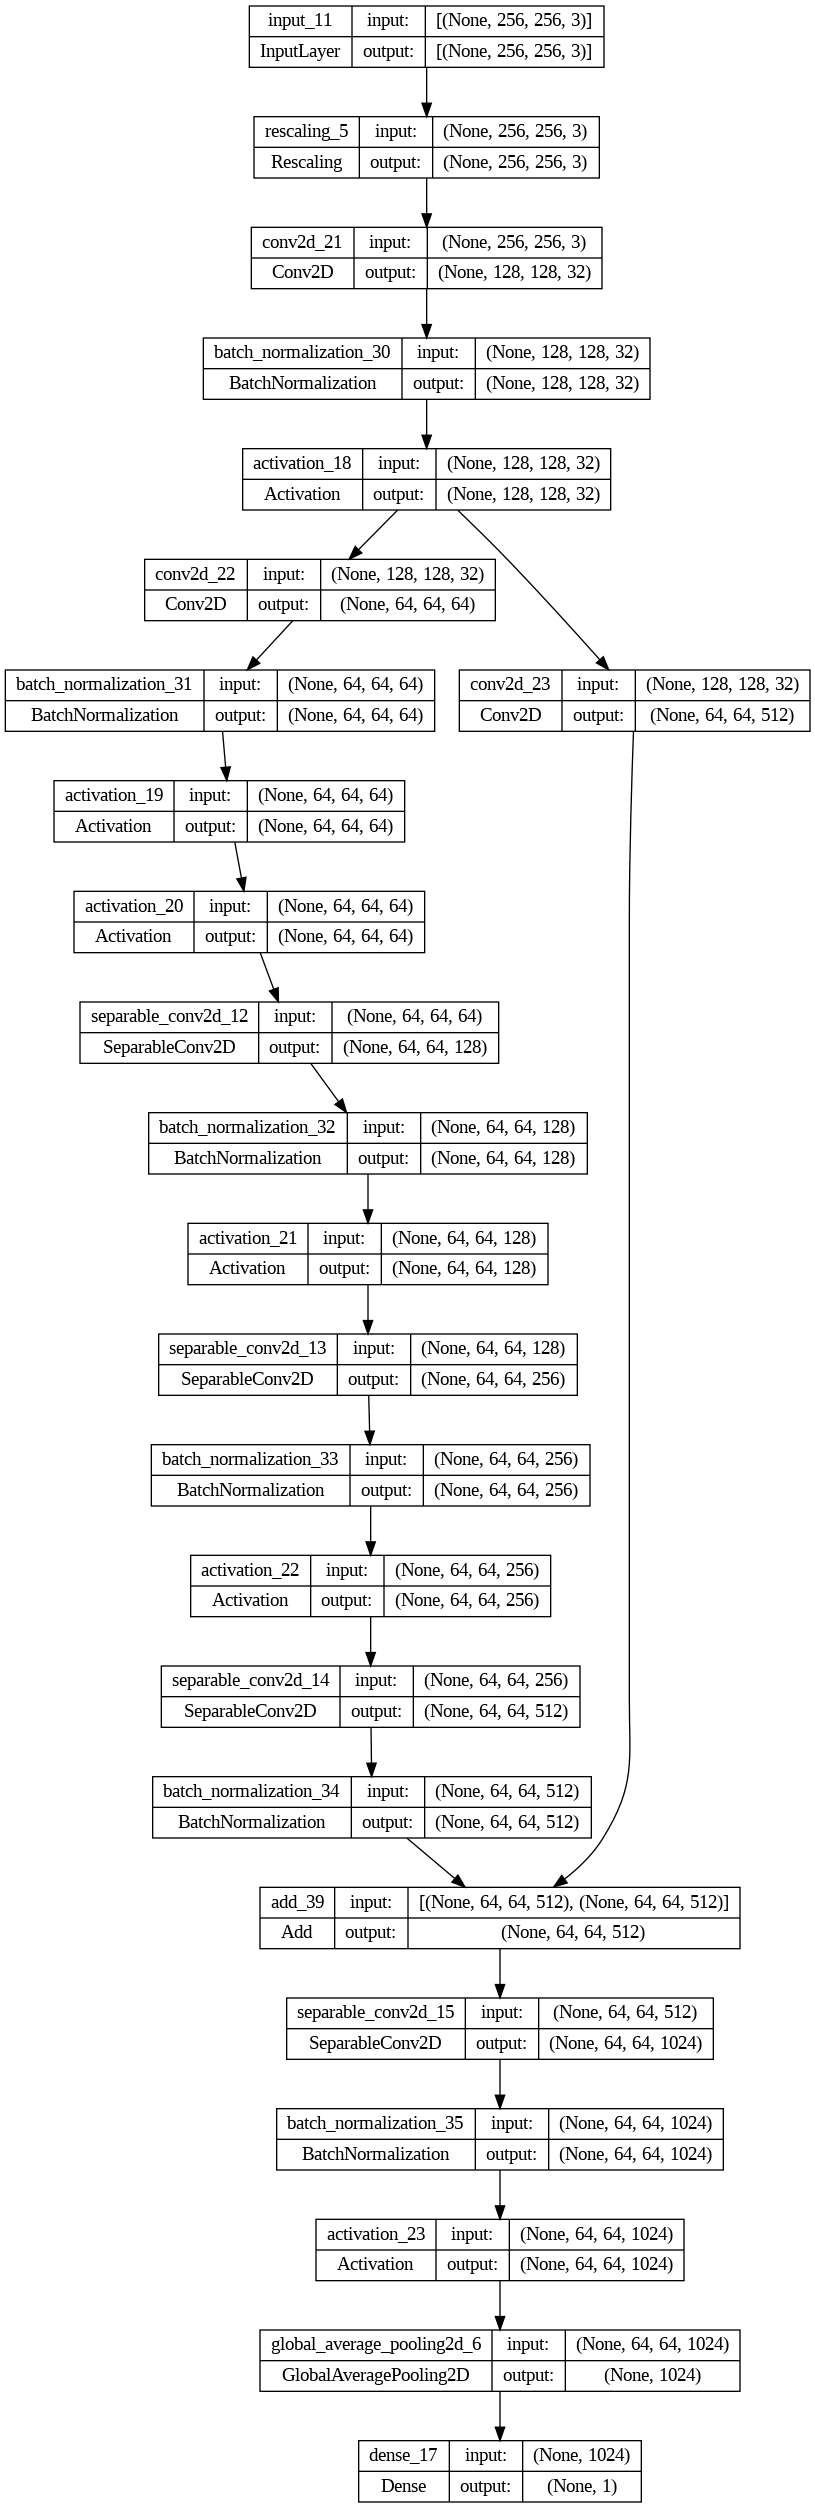

In [ ]:
#CNN Model based on ref: https://keras.io/examples/vision/image_classification_from_scratch/ 


def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)

    x = layers.Conv2D(32, (3,3), strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("ReLU")(x)

    previous_block_activation = x  # Set aside residual
    
    x = layers.Conv2D(64, (3,3), strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("ReLU")(x)

    x = layers.Activation("ReLU")(x)
    x = layers.SeparableConv2D(128, (3,3), padding="same")(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.Activation("ReLU")(x)
    x = layers.SeparableConv2D(256, (3,3), padding="same")(x)
    x = layers.BatchNormalization()(x)

    x = layers.Activation("ReLU")(x)
    x = layers.SeparableConv2D(512, (3,3), padding="same")(x)
    x = layers.BatchNormalization()(x)


    # Project residual
    residual = layers.Conv2D(512, (3,3), strides=2, padding="same")(
          previous_block_activation
      ) 
    x = layers.add([x, residual])  # Add back residual
    previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, (3,3), padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("ReLU")(x)

    x = layers.GlobalAveragePooling2D()(x)
    activation = "sigmoid"
    units = 1
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)
model = make_model(input_shape=(image_size) + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_5 (Rescaling)        (None, 256, 256, 3)  0           ['input_11[0][0]']               
                                                                                                  
 conv2d_21 (Conv2D)             (None, 128, 128, 32  896         ['rescaling_5[0][0]']            
                                )                                                                 
                                                                                            

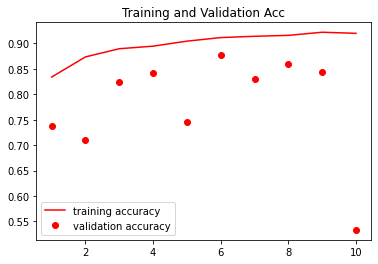

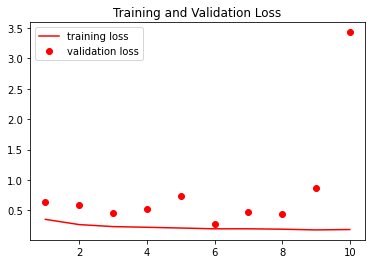

In [ ]:

epochs = 10

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=0.001,momentum=0.001),
    loss="binary_crossentropy",
    metrics=["acc"],
) 
model.summary()
history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds)
model.save('content/gdrive/My Drive/CNN_Models_Baseline/Extensive_COVID19_CT_modelAugmentedDCGAN.h5')
score = model.evaluate(test_ds)
print('Test Set loss: ' , score[0], ' Test Set accuracy: ', score[1])

print(history.history.keys())

accuracy = history.history['acc']
val_accuracy = history.history['val_acc']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(accuracy) + 1)
accuracy = history.history['acc']
val_accuracy = history.history['val_acc']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy,'r',label = 'training accuracy')
plt.plot(epochs, val_accuracy,'ro',label = 'validation accuracy')
plt.title('Training and Validation Acc')
plt.legend()
plt.show()

plt.plot(epochs, train_loss,'r',label = 'training loss')
plt.plot(epochs, val_loss,'ro',label = 'validation loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 dense_18 (Dense)            (None, 256)               524544    
                                                                 
 dense_19 (Dense)            (None, 1)                 257       
                                                                 
Total params: 21,386,281
Trainable params: 21,331,753
Non-trainable params: 54,528
_________________________________________________________________
Epoch 1/10
236/236 [==============================] - 31s 111ms/step - loss: 0.2116 - acc: 0.8997 - val_loss: 0.7462 - val_acc: 0.7431
Epoch 2/10
236/236 [==============================] - 25s 104ms/step - loss: 0.1141 - acc: 0.9555 - val_loss: 0.0812 - val_acc: 0.9713
Epoch 3/10
236/236 [===========

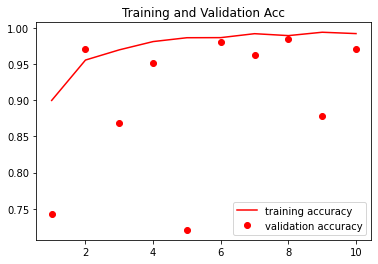

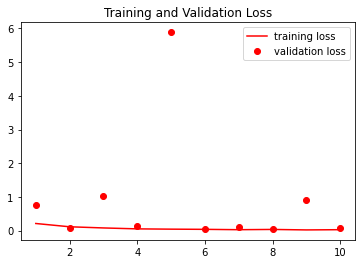

In [ ]:
# code inspired by page 145 - 148 deep learning with python
# and https://www.youtube.com/watch?v=JcU72smpLJk
Xception_model = Sequential()
model = tf.keras.applications.Xception(
    include_top=False,
    weights="imagenet",
    input_shape=(256,256,3),
    pooling='avg',
    classes=2,
    classifier_activation="sigmoid",
)
Xception_model.add(model)
Xception_model.add(Dense(256,activation='relu'))
Xception_model.add(Dense(1,activation='sigmoid'))
epochs = 10

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
Xception_model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=0.001,momentum=0.001),
    loss="binary_crossentropy",
    metrics=["acc"],
) 
Xception_model.summary()
history = Xception_model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds)
Xception_model.save('content/gdrive/My Drive/CNN_Models_Baseline/xception_extensive_covid_CT_modelAugmentedDCGAN.h5')
score = Xception_model.evaluate(test_ds)
print('Test Set loss: ' , score[0], ' Test Set accuracy: ', score[1])

print(history.history.keys())

accuracy = history.history['acc']
val_accuracy = history.history['val_acc']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(accuracy) + 1)
accuracy = history.history['acc']
val_accuracy = history.history['val_acc']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy,'r',label = 'training accuracy')
plt.plot(epochs, val_accuracy,'ro',label = 'validation accuracy')
plt.title('Training and Validation Acc')
plt.legend()
plt.show()

plt.plot(epochs, train_loss,'r',label = 'training loss')
plt.plot(epochs, val_loss,'ro',label = 'validation loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 2048)              23564800  
                                                                 
 dense_20 (Dense)            (None, 256)               524544    
                                                                 
 dense_21 (Dense)            (None, 1)                 257       
                                                                 
Total params: 24,089,601
Trainable params: 24,044,161
Non-trainable params: 45,440
_________________________________________________________________
Epoch 1/10
236/236 [==============================] - 26s 88ms/step - loss: 0.3757 - acc: 0.7994 - val_loss: 58.6020 - val_acc: 0.5092
Epoch 2/10
236/236 [==============================] - 19s 81ms/step - loss: 0.2546 - acc: 0.8621 - val_loss: 1.0499 - val_acc: 0.5832
Epoch 3/10
236/236 [============

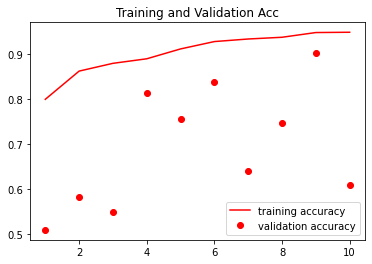

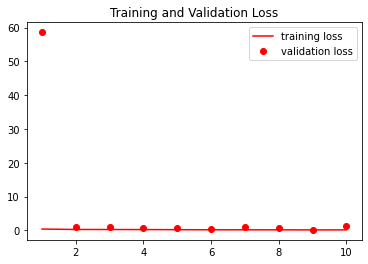

In [ ]:
# code inspired by page 145 - 148 deep learning with python
# and https://www.youtube.com/watch?v=JcU72smpLJk
ResnetModel50V2_model = Sequential()
model = tf.keras.applications.ResNet50V2(
    include_top=False,
    weights="imagenet",
    input_shape=(256,256,3),
    pooling='avg',
    classes=2,
    classifier_activation="sigmoid",
)
ResnetModel50V2_model.add(model)
ResnetModel50V2_model.add(Dense(256,activation='relu'))
ResnetModel50V2_model.add(Dense(1,activation='sigmoid'))
epochs = 10

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
ResnetModel50V2_model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=0.001,momentum=0.001),
    loss="binary_crossentropy",
    metrics=["acc"],
) 
ResnetModel50V2_model.summary()
history = ResnetModel50V2_model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds)
ResnetModel50V2_model.save('content/gdrive/My Drive/CNN_Models_Baseline/resnetmodel50v2_extensive_covid_CT_modelAugmentedDCGAN.h5')
score = ResnetModel50V2_model.evaluate(test_ds)
print('Test Set loss: ' , score[0], ' Test Set accuracy: ', score[1])

print(history.history.keys())

accuracy = history.history['acc']
val_accuracy = history.history['val_acc']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(accuracy) + 1)
accuracy = history.history['acc']
val_accuracy = history.history['val_acc']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy,'r',label = 'training accuracy')
plt.plot(epochs, val_accuracy,'ro',label = 'validation accuracy')
plt.title('Training and Validation Acc')
plt.legend()
plt.show()

plt.plot(epochs, train_loss,'r',label = 'training loss')
plt.plot(epochs, val_loss,'ro',label = 'validation loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-s (Functiona  (None, 1280)             20331360  
 l)                                                              
                                                                 
 dense_22 (Dense)            (None, 256)               327936    
                                                                 
 dense_23 (Dense)            (None, 1)                 257       
                                                                 
Total params: 20,659,553
Trainable params: 20,505,681
Non-trainable params: 153,872
_________________________________________________________________
Epoch 1/10
236/236 [==============================] - 58s 164ms/step - loss: 0.2182 - acc: 0.9044 - val_loss: 0.2705 - val_acc: 0.8845
Epoch 2/10
236/236 [==============================] - 36s 150ms/step - loss: 0.1324 - acc: 0.9463 -

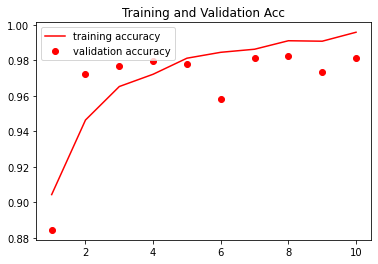

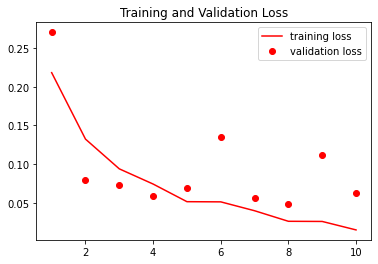

In [ ]:
# code inspired by page 145 - 148 deep learning with python
# and https://www.youtube.com/watch?v=JcU72smpLJk
EfficientNetV2S_model	= Sequential()
model = tf.keras.applications.EfficientNetV2S(
    include_top=False,
    weights="imagenet",
    input_shape=(256,256,3),
    pooling='avg',
    classes=2,
    classifier_activation="sigmoid",
)
EfficientNetV2S_model.add(model)
EfficientNetV2S_model.add(Dense(256,activation='relu'))
EfficientNetV2S_model.add(Dense(1,activation='sigmoid'))
epochs = 10

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
EfficientNetV2S_model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=0.001,momentum=0.001),
    loss="binary_crossentropy",
    metrics=["acc"],
) 
EfficientNetV2S_model.summary()
history = EfficientNetV2S_model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds)
EfficientNetV2S_model.save('content/gdrive/My Drive/CNN_Models_Baseline/efficient_net_V2S_extensive_covid_CT_modelAugmentedDCGAN.h5')
score = EfficientNetV2S_model.evaluate(test_ds)
print('Test Set loss: ' , score[0], ' Test Set accuracy: ', score[1])

print(history.history.keys())

accuracy = history.history['acc']
val_accuracy = history.history['val_acc']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(accuracy) + 1)
accuracy = history.history['acc']
val_accuracy = history.history['val_acc']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy,'r',label = 'training accuracy')
plt.plot(epochs, val_accuracy,'ro',label = 'validation accuracy')
plt.title('Training and Validation Acc')
plt.legend()
plt.show()

plt.plot(epochs, train_loss,'r',label = 'training loss')
plt.plot(epochs, val_loss,'ro',label = 'validation loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


# X-Ray CNNS

In [ ]:

#Loading of images based on ref: https://keras.io/examples/vision/image_classification_from_scratch/ 

image_size = (256, 256)
batch_size = 32
train_ds = tf.keras.utils.image_dataset_from_directory(extensive_COVID_database_X_Ray, validation_split=0.3,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    crop_to_aspect_ratio=True
)

val_ds = tf.keras.utils.image_dataset_from_directory(extensive_COVID_database_X_Ray, validation_split=0.3,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    crop_to_aspect_ratio=True
)
     
# create test set - https://stackoverflow.com/questions/66036271/splitting-a-tensorflow-dataset-into-training-test-and-validation-sets-from-ker
# 20 % now used for test and 10% used for validation
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take((2*val_batches) // 3)
val_ds = val_ds.skip((2*val_batches) // 3)


Found 10537 files belonging to 2 classes.
Using 7376 files for training.
Found 10537 files belonging to 2 classes.
Using 3161 files for validation.


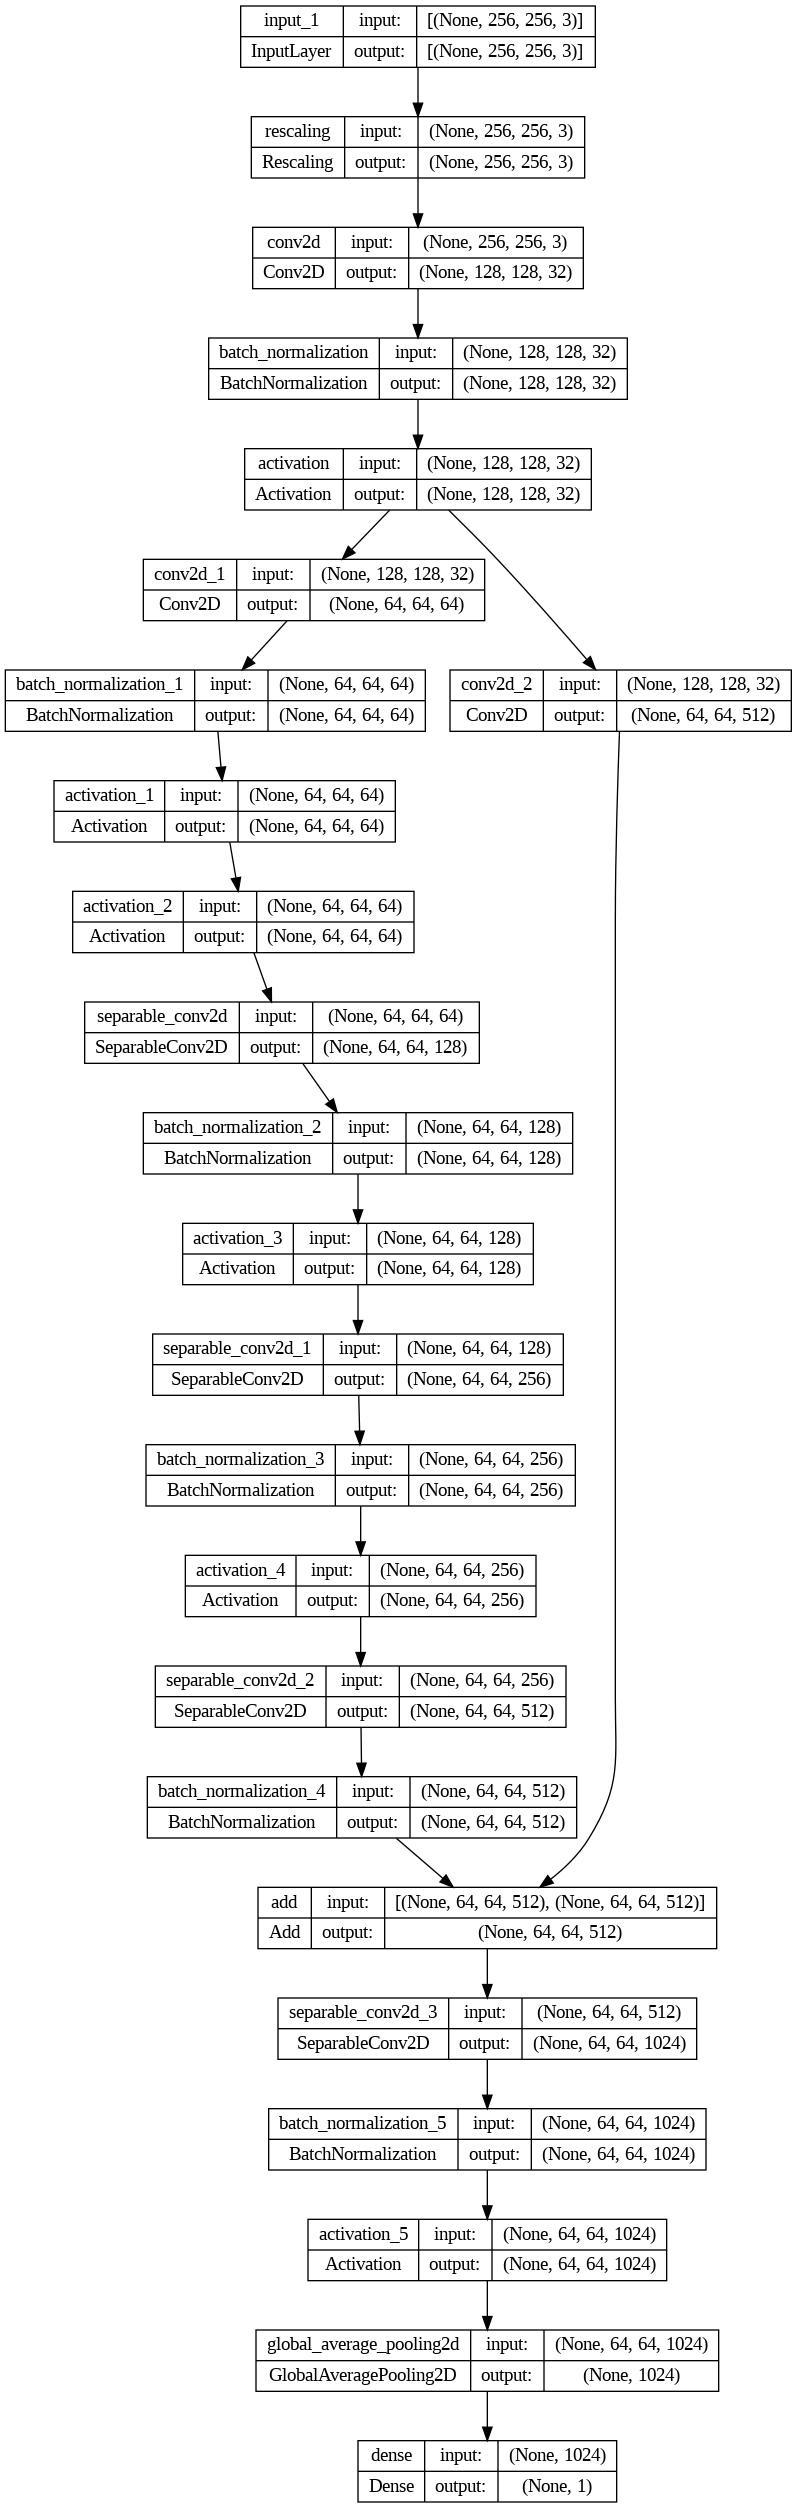

In [ ]:
#CNN Model based on ref: https://keras.io/examples/vision/image_classification_from_scratch/ 


def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)

    x = layers.Conv2D(32, (3,3), strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("ReLU")(x)

    previous_block_activation = x  # Set aside residual
    
    x = layers.Conv2D(64, (3,3), strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("ReLU")(x)

    x = layers.Activation("ReLU")(x)
    x = layers.SeparableConv2D(128, (3,3), padding="same")(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.Activation("ReLU")(x)
    x = layers.SeparableConv2D(256, (3,3), padding="same")(x)
    x = layers.BatchNormalization()(x)

    x = layers.Activation("ReLU")(x)
    x = layers.SeparableConv2D(512, (3,3), padding="same")(x)
    x = layers.BatchNormalization()(x)


    # Project residual
    residual = layers.Conv2D(512, (3,3), strides=2, padding="same")(
          previous_block_activation
      ) 
    x = layers.add([x, residual])  # Add back residual
    previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, (3,3), padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("ReLU")(x)

    x = layers.GlobalAveragePooling2D()(x)
    activation = "sigmoid"
    units = 1
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)
model = make_model(input_shape=(image_size) + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 256, 256, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 32  896         ['rescaling[0][0]']              
                                )                                                                 
                                                                                              

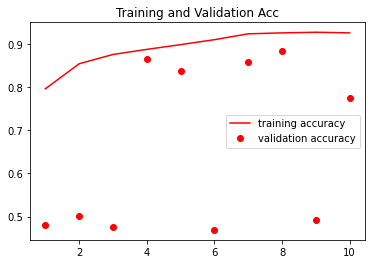

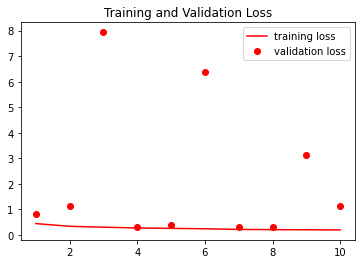

In [ ]:
epochs = 10

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=0.001,momentum=0.001),
    loss="binary_crossentropy",
    metrics=["acc"],
) 
model.summary()
history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds)
model.save('content/gdrive/My Drive/CNN_Models_Baseline/Extensive_COVID19_XRAY_modelAugmentedDCGAN.h5')
score = model.evaluate(test_ds)
print('Test Set loss: ' , score[0], ' Test Set accuracy: ', score[1])

print(history.history.keys())

accuracy = history.history['acc']
val_accuracy = history.history['val_acc']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(accuracy) + 1)
accuracy = history.history['acc']
val_accuracy = history.history['val_acc']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy,'r',label = 'training accuracy')
plt.plot(epochs, val_accuracy,'ro',label = 'validation accuracy')
plt.title('Training and Validation Acc')
plt.legend()
plt.show()

plt.plot(epochs, train_loss,'r',label = 'training loss')
plt.plot(epochs, val_loss,'ro',label = 'validation loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 dense_1 (Dense)             (None, 256)               524544    
                                                                 
 dense_2 (Dense)             (None, 1)                 257       
                                                                 
Total params: 21,386,281
Trainable params: 21,331,753
Non-trainable params: 54,528
_________________________________________________________________
Epoch 1/10
231/231 [==============================] - 40s 147ms/step - loss: 0.6926 - acc: 0.5244 - val_loss: 0.6939 - val_acc: 0.5043
Epoch 2/10
231/231 [==============================] - 33s 139ms/step - loss: 0.3463 - acc: 0.8467 - val_loss: 0.2406 - val_acc: 0.9409
Epoch 3/10
231/231 [=============

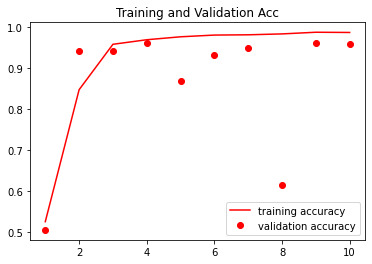

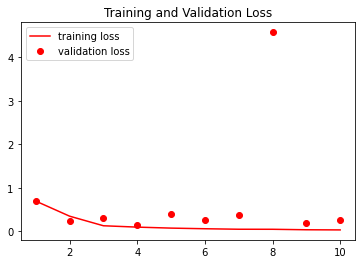

In [ ]:
# code inspired by page 145 - 148 deep learning with python
# and https://www.youtube.com/watch?v=JcU72smpLJk
Xception_model = Sequential()
model = tf.keras.applications.Xception(
    include_top=False,
    weights="imagenet",
    input_shape=(256,256,3),
    pooling='avg',
    classes=2,
    classifier_activation="sigmoid",
)
Xception_model.add(model)
Xception_model.add(Dense(256,activation='relu'))
Xception_model.add(Dense(1,activation='sigmoid'))
epochs = 10

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
Xception_model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=0.001,momentum=0.001),
    loss="binary_crossentropy",
    metrics=["acc"],
) 
Xception_model.summary()
history = Xception_model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds)
Xception_model.save('content/gdrive/My Drive/CNN_Models_Baseline/xception_extensive_covid_Xray_modelAugmentedDCGAN.h5')
score = Xception_model.evaluate(test_ds)
print('Test Set loss: ' , score[0], ' Test Set accuracy: ', score[1])

print(history.history.keys())

accuracy = history.history['acc']
val_accuracy = history.history['val_acc']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(accuracy) + 1)
accuracy = history.history['acc']
val_accuracy = history.history['val_acc']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy,'r',label = 'training accuracy')
plt.plot(epochs, val_accuracy,'ro',label = 'validation accuracy')
plt.title('Training and Validation Acc')
plt.legend()
plt.show()

plt.plot(epochs, train_loss,'r',label = 'training loss')
plt.plot(epochs, val_loss,'ro',label = 'validation loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 2048)              23564800  
                                                                 
 dense_3 (Dense)             (None, 256)               524544    
                                                                 
 dense_4 (Dense)             (None, 1)                 257       
                                                                 
Total params: 24,089,601
Trainable params: 24,044,161
Non-trainable params: 45,440
_________________________________________________________________
Epoch 1/10
231/231 [==============================] - 40s 145ms/step - loss: 0.3971 - acc: 0.8391 - val_loss: 1.5798 - val_acc: 0.8027
Epoch 2/10
231/231 [==============================] - 32s 136ms/step - loss: 0.2548 - acc: 0.8976 - val_loss: 0.6366 - val_acc: 0.7245
Epoch 3/10
231/231 [===========

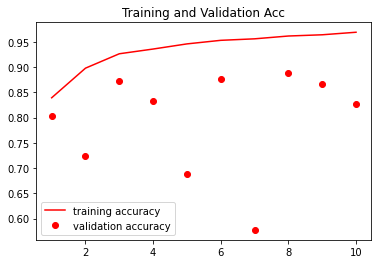

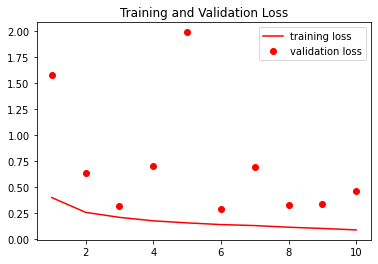

In [ ]:
# code inspired by page 145 - 148 deep learning with python
# and https://www.youtube.com/watch?v=JcU72smpLJk
ResnetModel50V2_model = Sequential()
model = tf.keras.applications.ResNet50V2(
    include_top=False,
    weights="imagenet",
    input_shape=(256,256,3),
    pooling='avg',
    classes=2,
    classifier_activation="sigmoid",
)
ResnetModel50V2_model.add(model)
ResnetModel50V2_model.add(Dense(256,activation='relu'))
ResnetModel50V2_model.add(Dense(1,activation='sigmoid'))
epochs = 10

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
ResnetModel50V2_model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=0.001,momentum=0.001),
    loss="binary_crossentropy",
    metrics=["acc"],
) 
ResnetModel50V2_model.summary()
history = ResnetModel50V2_model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds)
ResnetModel50V2_model.save('content/gdrive/My Drive/CNN_Models_Baseline/resnetmodel50v2_extensive_covid_Xray_modelAugmentedDCGAN.h5')
score = ResnetModel50V2_model.evaluate(test_ds)
print('Test Set loss: ' , score[0], ' Test Set accuracy: ', score[1])

print(history.history.keys())

accuracy = history.history['acc']
val_accuracy = history.history['val_acc']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(accuracy) + 1)
accuracy = history.history['acc']
val_accuracy = history.history['val_acc']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy,'r',label = 'training accuracy')
plt.plot(epochs, val_accuracy,'ro',label = 'validation accuracy')
plt.title('Training and Validation Acc')
plt.legend()
plt.show()

plt.plot(epochs, train_loss,'r',label = 'training loss')
plt.plot(epochs, val_loss,'ro',label = 'validation loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-s (Functiona  (None, 1280)             20331360  
 l)                                                              
                                                                 
 dense_5 (Dense)             (None, 256)               327936    
                                                                 
 dense_6 (Dense)             (None, 1)                 257       
                                                                 
Total params: 20,659,553
Trainable params: 20,505,681
Non-trainable params: 153,872
_________________________________________________________________
Epoch 1/10
231/231 [==============================] - 65s 194ms/step - loss: 0.2253 - acc: 0.9146 - val_loss: 0.2105 - val_acc: 0.9247
Epoch 2/10
231/231 [==============================] - 42s 178ms/step - loss: 0.1318 - acc: 0.9551 -

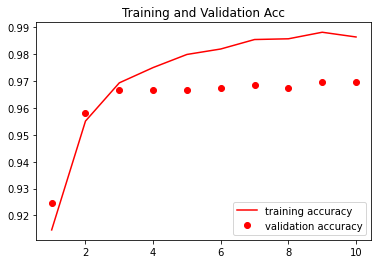

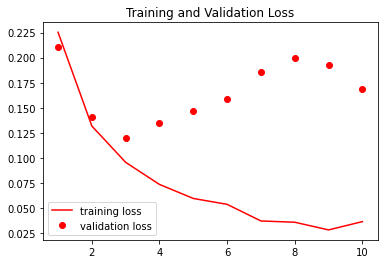

In [ ]:
# code inspired by page 145 - 148 deep learning with python
# and https://www.youtube.com/watch?v=JcU72smpLJk
EfficientNetV2S_model	= Sequential()
model = tf.keras.applications.EfficientNetV2S(
    include_top=False,
    weights="imagenet",
    input_shape=(256,256,3),
    pooling='avg',
    classes=2,
    classifier_activation="sigmoid",
)
EfficientNetV2S_model.add(model)
EfficientNetV2S_model.add(Dense(256,activation='relu'))
EfficientNetV2S_model.add(Dense(1,activation='sigmoid'))
epochs = 10

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
EfficientNetV2S_model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=0.001,momentum=0.001),
    loss="binary_crossentropy",
    metrics=["acc"],
) 
EfficientNetV2S_model.summary()
history = EfficientNetV2S_model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds)
EfficientNetV2S_model.save('content/gdrive/My Drive/CNN_Models_Baseline/efficient_net_V2S_extensive_covid_Xray_modelAugmentedDCGAN.h5')
score = EfficientNetV2S_model.evaluate(test_ds)
print('Test Set loss: ' , score[0], ' Test Set accuracy: ', score[1])

print(history.history.keys())

accuracy = history.history['acc']
val_accuracy = history.history['val_acc']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(accuracy) + 1)
accuracy = history.history['acc']
val_accuracy = history.history['val_acc']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy,'r',label = 'training accuracy')
plt.plot(epochs, val_accuracy,'ro',label = 'validation accuracy')
plt.title('Training and Validation Acc')
plt.legend()
plt.show()

plt.plot(epochs, train_loss,'r',label = 'training loss')
plt.plot(epochs, val_loss,'ro',label = 'validation loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()
     


### Testing each augmented model on the original datasets

In [ ]:
#Loading of images based on ref: https://keras.io/examples/vision/image_classification_from_scratch/ 

image_size = (256, 256)
batch_size = 32
train_ds = tf.keras.utils.image_dataset_from_directory(extensive_COVID_database_CT, validation_split=0.3,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    crop_to_aspect_ratio=True
)

val_ds = tf.keras.utils.image_dataset_from_directory(extensive_COVID_database_CT, validation_split=0.3,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    crop_to_aspect_ratio=True
)
# create test set - https://stackoverflow.com/questions/66036271/splitting-a-tensorflow-dataset-into-training-test-and-validation-sets-from-ker
# 20 % now used for test and 10% used for validation
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take((2*val_batches) // 3)
val_ds = val_ds.skip((2*val_batches) // 3)


Found 8054 files belonging to 2 classes.
Using 5638 files for training.
Found 8054 files belonging to 2 classes.
Using 2416 files for validation.


In [ ]:
test_model = load_model('/content/gdrive/My Drive/CNNFinalModelsMasters/CNNModels/Augmented Models/Extensive COVID19/Extensive_COVID19_CT_modelAugmentedDCGAN.h5')
test_model.evaluate(test_ds)

50/50 [==============================] - 124s 1s/step - loss: 4.5256 - acc: 0.3862


[4.525620937347412, 0.38624998927116394]

In [ ]:
xception_test_model = load_model('/content/gdrive/My Drive/CNNFinalModelsMasters/CNNModels/Augmented Models/Extensive COVID19/xception_extensive_covid_CT_modelAugmentedDCGAN.h5')
xception_test_model.evaluate(test_ds)

50/50 [==============================] - 3s 34ms/step - loss: 0.0658 - acc: 0.9762


[0.06576167792081833, 0.9762499928474426]

In [ ]:
resnet50V2_test_model = load_model('/content/gdrive/My Drive/CNNFinalModelsMasters/CNNModels/Augmented Models/Extensive COVID19/resnetmodel50v2_extensive_covid_CT_modelAugmentedDCGAN.h5')
resnet50V2_test_model.evaluate(test_ds)

50/50 [==============================] - 3s 35ms/step - loss: 0.5511 - acc: 0.7925


[0.5511321425437927, 0.7925000190734863]

In [ ]:
efficientNetV2S_test_model = load_model('/content/gdrive/My Drive/CNNFinalModelsMasters/CNNModels/Augmented Models/Extensive COVID19/efficient_net_V2S_extensive_covid_CT_modelAugmentedDCGAN.h5')
efficientNetV2S_test_model.evaluate(test_ds)

50/50 [==============================] - 5s 37ms/step - loss: 0.0458 - acc: 0.9894


[0.04584841802716255, 0.9893749952316284]

In [ ]:
#Loading of images based on ref: https://keras.io/examples/vision/image_classification_from_scratch/ 

image_size = (256, 256)
batch_size = 32
train_ds = tf.keras.utils.image_dataset_from_directory(extensive_COVID_database_X_Ray, validation_split=0.3,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    crop_to_aspect_ratio=True
)

val_ds = tf.keras.utils.image_dataset_from_directory(extensive_COVID_database_X_Ray, validation_split=0.3,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    crop_to_aspect_ratio=True
)
     
# create test set - https://stackoverflow.com/questions/66036271/splitting-a-tensorflow-dataset-into-training-test-and-validation-sets-from-ker
# 20 % now used for test and 10% used for validation
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take((2*val_batches) // 3)
val_ds = val_ds.skip((2*val_batches) // 3)

Found 9537 files belonging to 2 classes.
Using 6676 files for training.
Found 9537 files belonging to 2 classes.
Using 2861 files for validation.


In [ ]:
test_model = load_model('/content/gdrive/My Drive/CNNFinalModelsMasters/CNNModels/Augmented Models/Extensive COVID19/Extensive_COVID19_XRAY_modelAugmentedDCGAN.h5')
test_model.evaluate(test_ds)

60/60 [==============================] - 213s 1s/step - loss: 1.0930 - acc: 0.7776


[1.092952013015747, 0.7776041626930237]

In [ ]:
xception_test_model = load_model('/content/gdrive/My Drive/CNNFinalModelsMasters/CNNModels/Augmented Models/Extensive COVID19/xception_extensive_covid_Xray_modelAugmentedDCGAN.h5')
xception_test_model.evaluate(test_ds)

60/60 [==============================] - 8s 102ms/step - loss: 0.1404 - acc: 0.9734


[0.1403939574956894, 0.973437488079071]

In [ ]:
resnet50V2_test_model = load_model('/content/gdrive/My Drive/CNNFinalModelsMasters/CNNModels/Augmented Models/Extensive COVID19/resnetmodel50v2_extensive_covid_Xray_modelAugmentedDCGAN.h5')
resnet50V2_test_model.evaluate(test_ds)

60/60 [==============================] - 9s 99ms/step - loss: 0.4402 - acc: 0.8234


[0.44021186232566833, 0.823437511920929]

In [ ]:
efficientNetV2S_test_model = load_model('/content/gdrive/My Drive/CNNFinalModelsMasters/CNNModels/Augmented Models/Extensive COVID19/efficient_net_V2S_extensive_covid_Xray_modelAugmentedDCGAN.h5')
efficientNetV2S_test_model.evaluate(test_ds)

60/60 [==============================] - 10s 99ms/step - loss: 0.0783 - acc: 0.9797


[0.07833785563707352, 0.979687511920929]